In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install pyarrow
!pip install pygam
!pip install shap

     |████████████████████████████████| 1.8MB 3.0MB/s 
     |████████████████████████████████| 235kB 3.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/93/3f/4a/331cf71b5043416aeba0df795e7c204c7ad277673f1938d11b
Successfully built shap


## Imports

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import math
import re

from tqdm import tqdm
from collections import Counter

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
from pygam import LogisticGAM
import xgboost as xgb

import shap  # package used to calculate Shap values

import warnings
warnings.simplefilter(action='ignore')

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/grab/'
os.chdir(PATH)

In [0]:
PATH_LABELS = PATH + 'safety/labels'
PATH_FEATURES = PATH + 'safety/features'

run_model = False

## Read in
Start working from the aggregated dataframe produced from `preprocess`.

In [113]:
train_df = pd.read_feather(f'{PATH_FEATURES}/agg_train')

# # UNCOMMENT
# test_df = pd.read_feather(f'{PATH_FEATURES}/agg_test')

train_df.head()

,bookingID,Accuracy_max,Accuracy_mean,Accuracy_std,Bearing_max,Bearing_mean,Bearing_std,acceleration_x_max,acceleration_x_mean,acceleration_x_std,acceleration_y_max,acceleration_y_mean,acceleration_y_std,acceleration_z_max,acceleration_z_mean,acceleration_z_std,gyro_x_max,gyro_x_mean,gyro_x_std,gyro_y_max,gyro_y_mean,gyro_y_std,gyro_z_max,gyro_z_mean,gyro_z_std,second_max,second_mean,second_std,Speed_max,Speed_mean,Speed_std,total_a_max,total_a_mean,total_a_std,total_gyro_max,total_gyro_mean,total_gyro_std,roll_max,roll_mean,roll_std,...,roll_gyro_mean_abs_change,roll_gyro_longest_strike_above_mean,roll_gyro_number_peaks,pitch_count_above_mean,pitch_absolute_sum_of_changes,pitch_kurtosis,pitch_mean_abs_change,pitch_longest_strike_above_mean,pitch_number_peaks,pitch_gyro_count_above_mean,pitch_gyro_absolute_sum_of_changes,pitch_gyro_kurtosis,pitch_gyro_mean_abs_change,pitch_gyro_longest_strike_above_mean,pitch_gyro_number_peaks,xy_count_above_mean,xy_absolute_sum_of_changes,xy_kurtosis,xy_mean_abs_change,xy_longest_strike_above_mean,xy_number_peaks,xz_count_above_mean,xz_absolute_sum_of_changes,xz_kurtosis,xz_mean_abs_change,xz_longest_strike_above_mean,xz_number_peaks,yz_count_above_mean,yz_absolute_sum_of_changes,yz_kurtosis,yz_mean_abs_change,yz_longest_strike_above_mean,yz_number_peaks,horsepower_count_above_mean,horsepower_absolute_sum_of_changes,horsepower_kurtosis,horsepower_mean_abs_change,horsepower_longest_strike_above_mean,horsepower_number_peaks,label
0,0,48.000,10.165339,3.855898,359.979767,176.526099,129.231351,4.782614,-0.711264,0.928022,-6.119916,-9.613822,0.639934,2.318857,-1.619658,1.141266,0.438371,0.003328,0.065954,0.469724,-0.006118,0.100225,0.372807,-0.004188,0.063685,1589.0,903.526892,533.745097,22.946083,8.994822,7.199919,12.988328,9.886164,0.624159,0.749086,0.100772,0.091389,-1.347602,-1.737242,0.116742,...,2.075329,8.0,145.0,497.0,102.344479,2.810570,0.102038,9.0,140.0,512.0,755.723841,-0.736748,0.753463,14.0,143.0,522.0,9551.619582,4.090696,9.523050,9.0,141.0,493.0,2038.600043,13.401726,2.032503,7.0,144.0,504.0,11925.041609,1.350515,11.889373,9.0,145.0,488.0,81993.082902,-1.345483,81.747839,10.0,145.0,0
1,1,7.709,3.718763,0.597933,337.000000,124.198590,89.861236,3.813341,-0.525406,0.744157,12.536156,9.532086,0.533915,1.481293,-2.198999,0.854271,0.126536,-0.002467,0.027740,0.470837,-0.007540,0.091699,0.235131,0.000405,0.033838,1034.0,581.175088,289.339367,21.882141,7.881588,7.059362,12.790147,9.862507,0.519956,0.717864,0.066187,0.077463,2.137340,1.797626,0.088049,...,1.926214,6.0,128.0,450.0,60.912825,9.103572,0.071662,9.0,118.0,428.0,479.129018,0.268895,0.563681,8.0,118.0,404.0,5823.028637,8.430872,6.850622,7.0,122.0,398.0,1609.847652,8.209637,1.893938,9.0,119.0,432.0,7121.632447,1.965001,8.378391,10.0,116.0,408.0,65896.089220,-1.184823,77.524811,8.0,120.0,1
2,2,8.000,3.930626,1.117354,354.000000,173.794872,119.316520,1.956122,0.306786,0.756589,13.333716,9.843183,0.505693,2.312870,0.139347,1.020021,0.282162,0.006458,0.053903,0.431695,-0.012861,0.117321,0.255884,0.002597,0.036215,825.0,339.441026,356.319445,9.360483,3.157213,2.897762,13.403410,9.929590,0.515173,0.463685,0.097433,0.093028,1.891112,1.556422,0.102860,...,1.948800,5.0,27.0,82.0,16.339258,0.593341,0.084223,6.0,24.0,109.0,132.576111,-0.083263,0.683382,9.0,27.0,114.0,1603.957903,2.164108,8.267824,7.0,25.0,94.0,164.650951,7.386813,0.848716,7.0,25.0,114.0,2143.264543,1.254870,11.047755,10.0,27.0,92.0,6625.433409,-0.968787,34.151719,6.0,25.0,1
3,4,10.000,10.000000,0.000000,353.855377,151.807013,71.273774,2.019635,-0.365117,0.527220,-7.064984,-9.406439,0.598023,0.296381,-2.613639,0.779529,0.438732,-0.022884,0.042342,0.652628,0.023232,0.112567,0.505220,-0.000376,0.065927,1094.0,547.495430,315.962793,19.780001,6.150996,5.595901,21.053265,9.813434,0.620066,0.661675,0.108875,0.089501,-1.537207,-1.841256,0.077592,...,1.823237,9.0,152.0,569.0,59.966909,4.773294,0.054865,10.0,156.0,464.0,522.945465,0.628114,0.478450,6.0,158.0,578.0,5441.684036,4.874346,

In [0]:
# def encode_FE(df, col):
#     cv = df[col].value_counts()
#     nm = col+'_FE'
#     df[nm] = df[col].map(cv)
    
# freq_features = ['gyro_x_mean', 'gyro_z_so_mean', 'total_gyro_mean',
#                  'roll_max', 'Speed_min', 'total_gyro_min', 
#                  'horsepower_min', 'Bearing_min']    
    
# for c in freq_features:     
#   encode_FE(train_df, c)

## Feature selection
For the first run, select all 149 features but after running `lightgbm` twice and narrowing the important features into half each run, we are left with 37 features. The 37 features here manage to achieve a higher AUC-ROC score compared to 149 features.

In [143]:
exclude = ['label', 'bookingID']

# if we have not run the model to 
# narrow down the features,
# start with 149 features
if not run_model:
    features = [c for c in train_df.columns if c not in exclude]
    
else:
    features = features_df['features'].tolist()
  
    features = ['second_kurtosis', 'pitch_max', 'Speed_max', 
                'roll_gyro_kurtosis', 'xz_kurtosis', 'Speed_mean', 
                'horsepower_mean', 'Bearing_std', 'gyro_z_mean_abs_change', 
                'Bearing_mean_abs_change', 'yz_kurtosis', 'acceleration_z_std',
                'gyro_y_mean', 'Bearing_kurtosis', 'second_std', 
                'roll_std', 'horsepower_kurtosis', 'second_mean', 
                'acceleration_z_max', 'acceleration_z_kurtosis', 
                'gyro_y_max', 'xz_mean']
    
len(features)

22

## Model 1
### Lightgbm
First, run `lightgbm` and perform feature selection by retaining the top half important features for each run.

In [0]:
# ==================
# set random seed and
# use StratifiedKFold 
# for validation
# ==================
random_state = 42
np.random.seed(random_state)

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

In [0]:
# ==================
# out of fold validation
# ==================
val_aucs = []
feature_importance_df = pd.DataFrame()

oof = train_df[['bookingID', 'label']]
oof['predict'] = 0
oof = oof.reset_index()

In [0]:
# ==================
# lgb params
# ==================
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'verbose': 1,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.7,
    'min_data_in_leaf': 200,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'lambda_l1': 5,
    'lambda_l2': 5,
    'min_hessian': 0.01,
    'feature_fraction_seed': 2,
    'bagging_seed': 3,
    "seed": random_state
}

In [147]:
%%time
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['label']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['label']
    
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    evals_result = {}
    
    lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        500,
                        valid_sets=[trn_data, val_data],
                        early_stopping_rounds=100,
                        verbose_eval=100,
                        evals_result=evals_result)

    p_valid = lgb_clf.predict(X_valid[features], 
                              num_iteration=lgb_clf.best_iteration)

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.814409	valid_1's auc: 0.73725
[200]	training's auc: 0.859397	valid_1's auc: 0.73762
[300]	training's auc: 0.893094	valid_1's auc: 0.735322
Early stopping, best iteration is:
[202]	training's auc: 0.860068	valid_1's auc: 0.737777
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.813757	valid_1's auc: 0.736656
[200]	training's auc: 0.859383	valid_1's auc: 0.737801
[300]	training's auc: 0.892091	valid_1's auc: 0.734748
Early stopping, best iteration is:
[212]	training's auc: 0.863501	valid_1's auc: 0.738437
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.808869	valid_1's auc: 0.757227
[200]	training's auc: 0.856268	valid_1's auc: 0.755632
Early stopping, best iteration is:
[142]	training's auc: 0.831212	valid_1's auc: 0.758169
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.81202	valid_1's 

In [148]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['label'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.738255887, std: 0.010855761. All auc: 0.738019807.


Record `auc` score for every run after halfing the number of features
*   180 features: 0.7363
*   90 features: 0.7369
*   45 features: 0.7366
*   22 features: 0.7380

In [0]:
# features

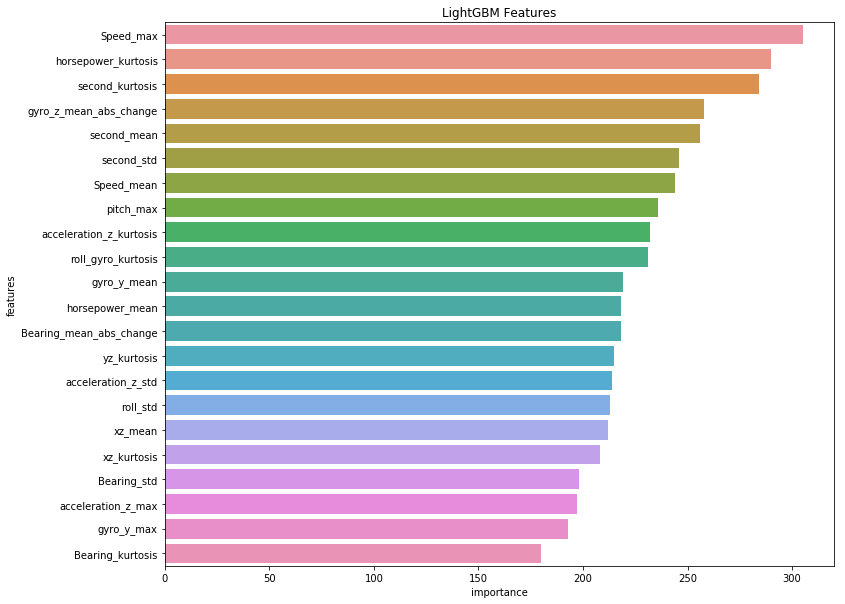

In [151]:
# ran model, set flag to true
run_model = True

feature_score = lgb_clf.feature_importance()

features_df = pd.DataFrame({'features': features,
                            'importance': feature_score})

features_df = features_df.sort_values('importance', ascending=False)

# only plot feature importance 
# for final run
if len(features_df) < 40:
    plt.figure(figsize=(12,10))
    sns.barplot(x="importance", y="features", 
                data=features_df)
    plt.title('LightGBM Features')
    plt.show()

# retain top half important features
if (len(features) > 40):
    features_df = features_df[:int(len(features)/2)]

## Model 2
### Generalized Additive Model
Run `pygam`. Start by selecting smoothing parameters `lam` by doing a `random grid search`.

In [0]:
# ==================
# scale the features
# ==================
s = StandardScaler()

X = s.fit_transform(train_df[features].values)
y = train_df['label'].values

In [0]:
# ==================
# random search for  
# smoothing parameters (lambda)
# code from pygam's documentation
# ==================
np.random.seed(0)
lams = np.random.rand(5, 22) # random points on [0, 1], with shape (100, 3)
lams = lams * 8 - 3 # shift values to -3, 3
lams = np.exp(lams) 

In [184]:
# ==================
# fit the model
# ==================
%%time
gam = LogisticGAM().gridsearch(X, y, 
                               lam=lams,
                               keep_best=True)

100% (5 of 5) |##########################| Elapsed Time: 0:02:19 Time:  0:02:19


CPU times: user 3min 54s, sys: 26.1 s, total: 4min 20s
Wall time: 2min 19s


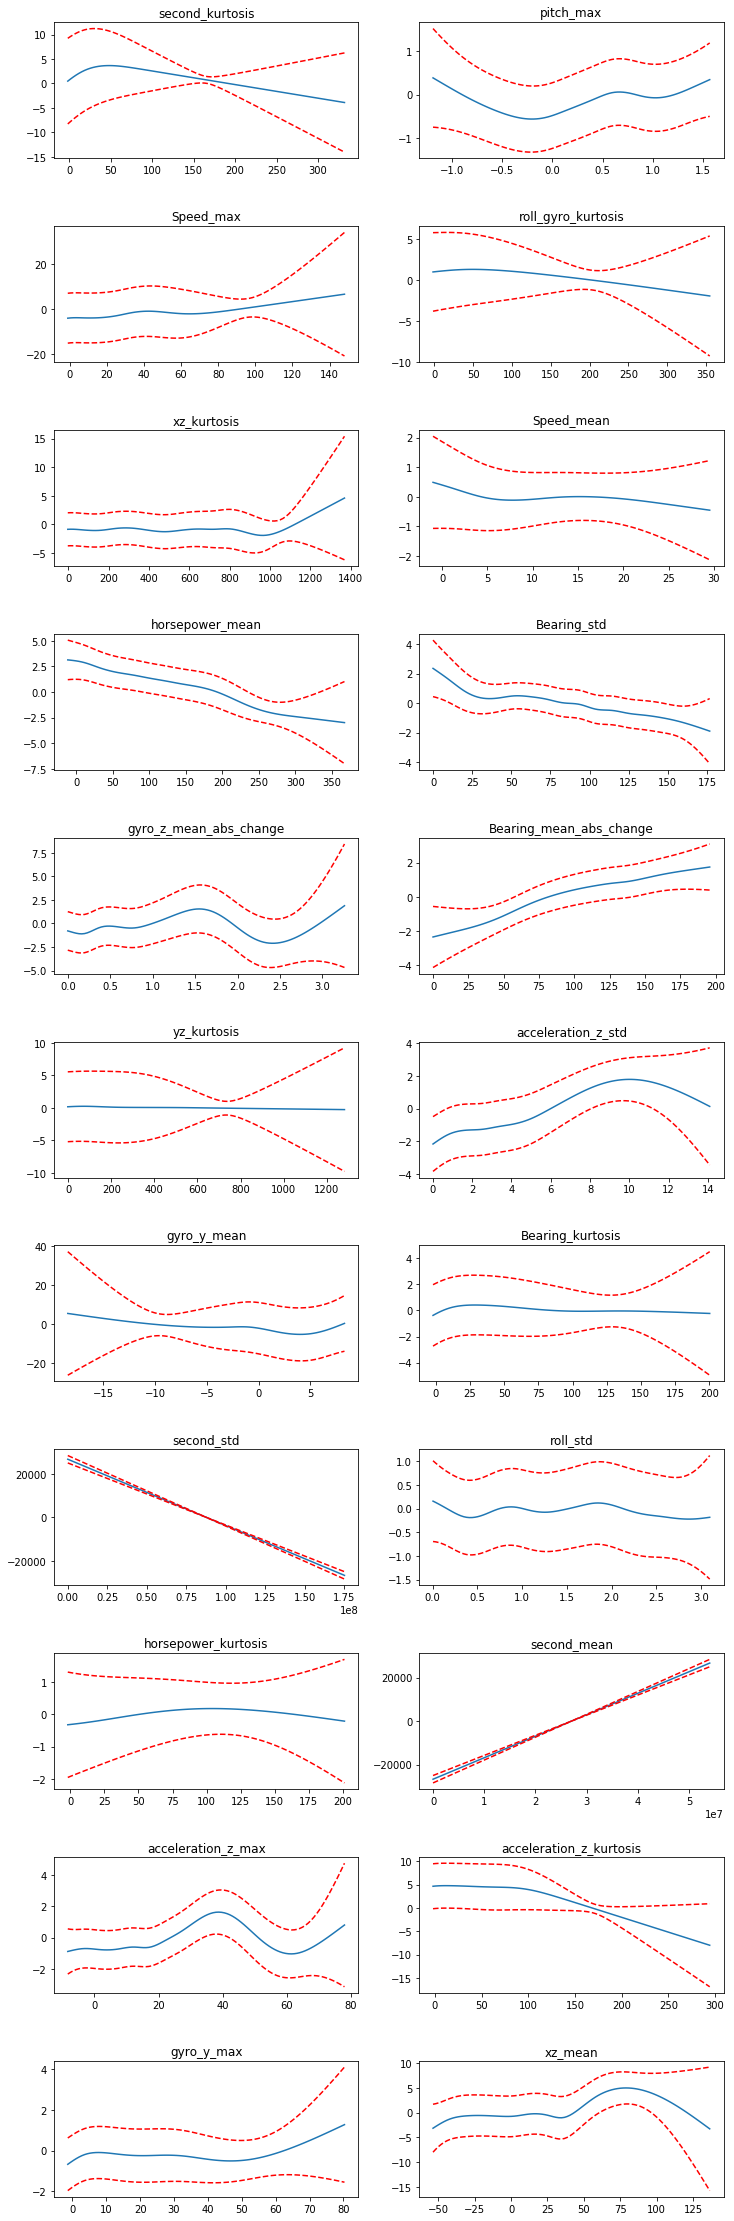

In [200]:
# ==================
# partial dependence plot
# on all features
# ==================
plt.figure(figsize=(12,40))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
        
    plt.subplot(11, 2, i+1)
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')    
    plt.title(features[i])
    plt.subplots_adjust(hspace=0.5)
    
plt.show()

In [186]:
# ==================
# check for accuracy
# ==================
gam.accuracy(X, y)

0.77205

In [187]:
# ==================
# logistic GAM statistic summary
# ==================
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                    104.5651
Link Function:                        LogitLink Log Likelihood:                                 -9843.6559
Number of Samples:                        20000 AIC:                                            19896.4421
                                                AICc:                                           19897.5731
                                                UBRE:                                                2.999
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1248
Feature Function                  Lam

In [0]:
# ==================
# using the best lambdas
# found, perform KFold
# ==================
random_state = 42
np.random.seed(random_state)

folds = 4
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

val_aucs = []
feature_importance_df = pd.DataFrame()

oof = train_df[['bookingID', 'label']]
oof['predict'] = 0
oof = oof.reset_index()

In [192]:
%%time
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
  
    X_train = train_df.iloc[trn_idx][features].values
    y_train = train_df.iloc[trn_idx]['label'].values
    X_valid = train_df.iloc[val_idx][features].values
    y_valid = train_df.iloc[val_idx]['label'].values
    
    gam = LogisticGAM(lam=gam.lam).fit(X_train, y_train)        
    
    p_valid = gam.predict_proba(X_valid)
    
    # ==================
    # impute NaN with 0
    # ==================
    nans = np.where(np.isnan(p_valid))
    
    for i in nans:
        p_valid[i] = 0

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    
    print('fold {}\'s auc: {}'.format(fold+1, val_score))
    
    val_aucs.append(val_score)

fold 1's auc: 0.7049517719158006
fold 2's auc: 0.7495722666666668
fold 3's auc: 0.71045888
fold 4's auc: 0.7123845292077888
CPU times: user 3min 4s, sys: 21 s, total: 3min 25s
Wall time: 1min 49s


In [193]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['label'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.719341862, std: 0.017665389. All auc: 0.719848243.


## Model 3
### XGBoost

In [0]:
random_state = 42
np.random.seed(random_state)

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

val_aucs = []
feature_importance_df = pd.DataFrame()

oof = train_df[['bookingID', 'label']]
oof['predict'] = 0
oof = oof.reset_index()

In [0]:
# ==================
# xgb params
# ==================
xgb_params = {
    'objective':'binary:logistic',
    'metric': 'auc',
    'verbose': 1,
    'learning_rate': 0.05,
    'max_depth': 5,
    "seed": random_state
}

In [170]:
len(features)

22

In [171]:
%%time
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['label']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['label']
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_valid, label=y_valid)
        
    xgb_clf = xgb.train(xgb_params,
                        dtrain,
                        5000,
                        evals=[(dtrain, 'train'), (dtest, 'valid')],
                        early_stopping_rounds=100,
                        verbose_eval=100)

    p_valid = xgb_clf.predict(dtest,
                              ntree_limit=xgb_clf.best_ntree_limit)

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)

[0]	train-error:0.220201	valid-error:0.227193
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 100 rounds.
[100]	train-error:0.1992	valid-error:0.221945
Stopping. Best iteration:
[40]	train-error:0.208576	valid-error:0.220195

[0]	train-error:0.2195	valid-error:0.2195
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 100 rounds.
[100]	train-error:0.1985	valid-error:0.21225
Stopping. Best iteration:
[91]	train-error:0.200625	valid-error:0.2105

[0]	train-error:0.216688	valid-error:0.225
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 100 rounds.
[100]	train-error:0.198812	valid-error:0.21975
[200]	train-error:0.1855	valid-error:0.2175
[300]	train-error:0.172063	valid-error:0.21825
Stopping. Best iteration:
[234]	train-error:0.1808

In [172]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['label'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.734888008, std: 0.009023799. All auc: 0.732362901.


## Interpretation
Understanding each feature from the best  model, `lightgbm` using `shap`.

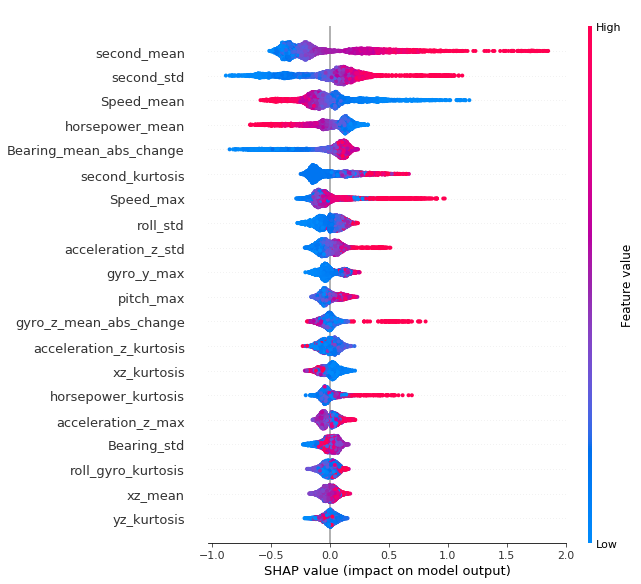

In [173]:
shap_values = shap.TreeExplainer(lgb_clf).shap_values(X_valid)

shap.summary_plot(shap_values, X_valid)

Draw partial depedence plot for the 37 features.

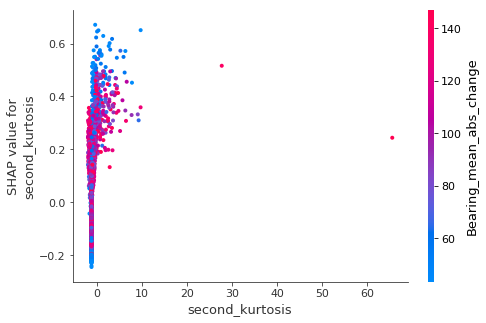

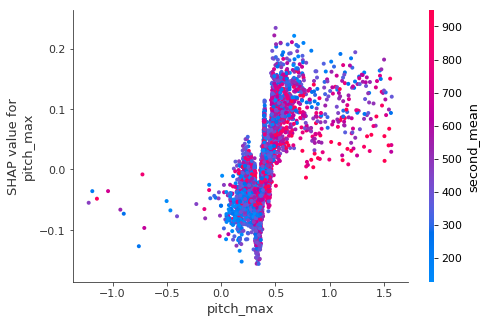

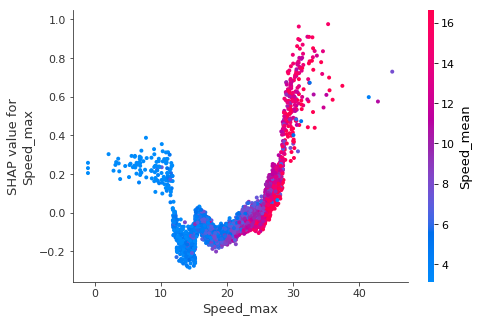

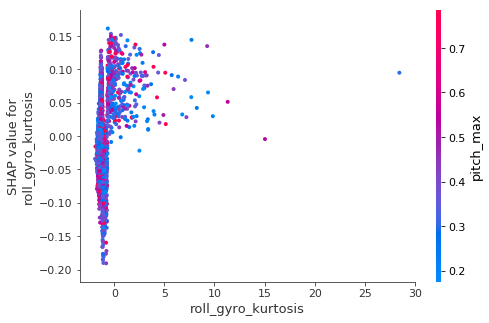

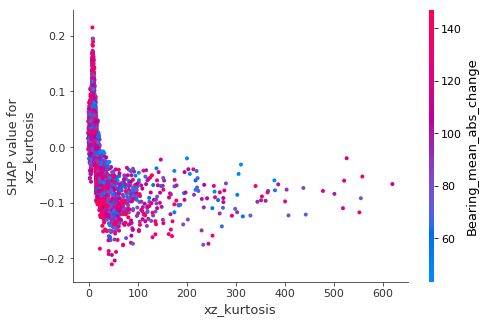

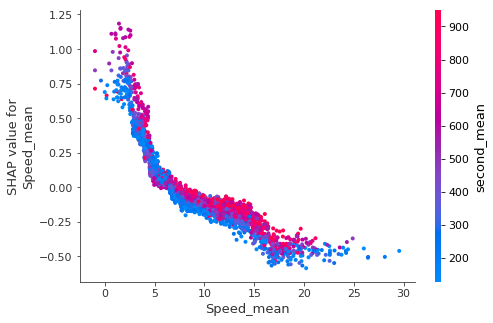

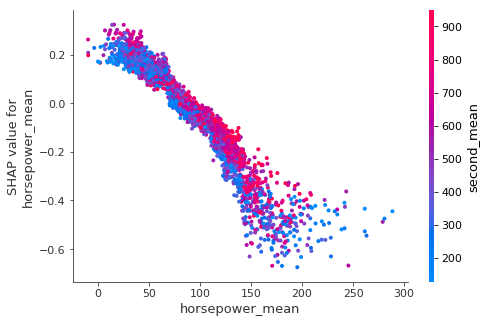

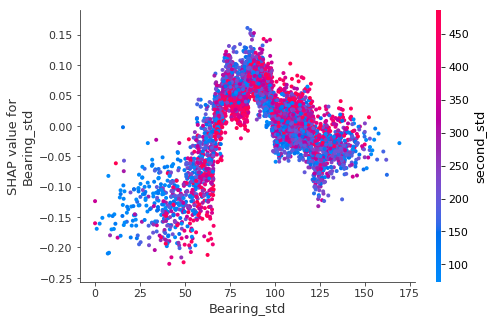

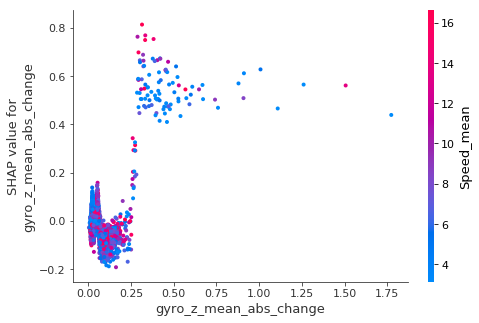

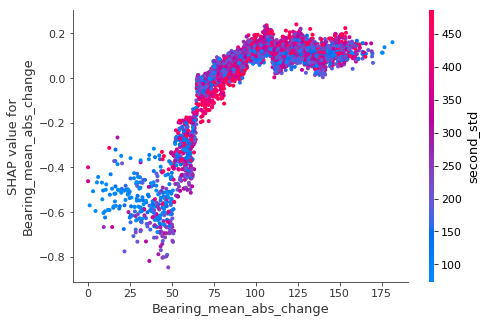

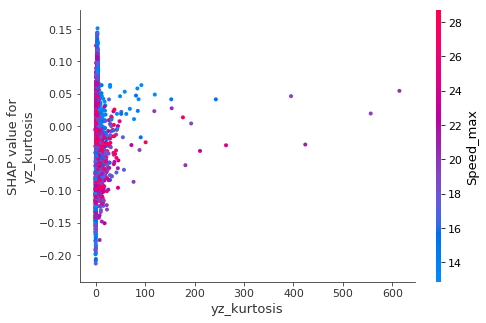

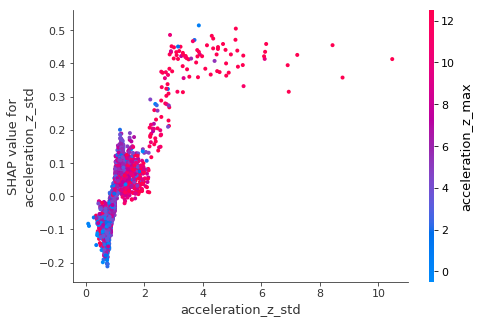

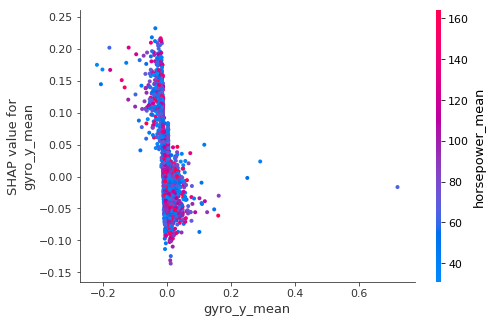

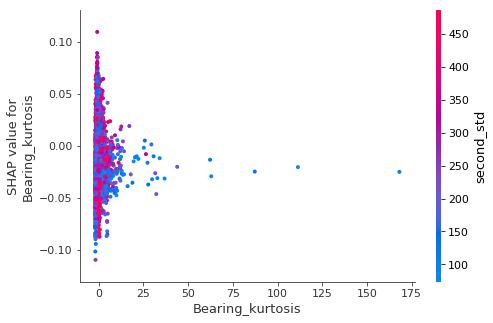

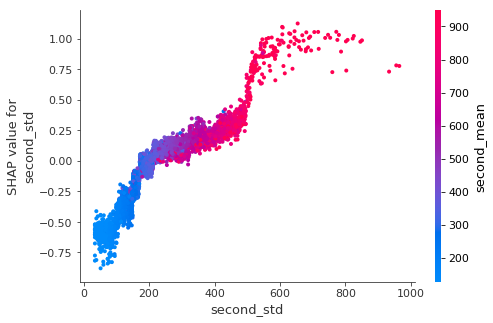

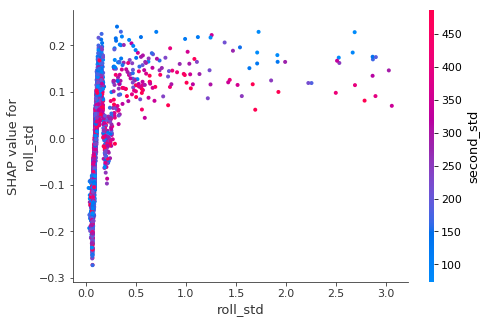

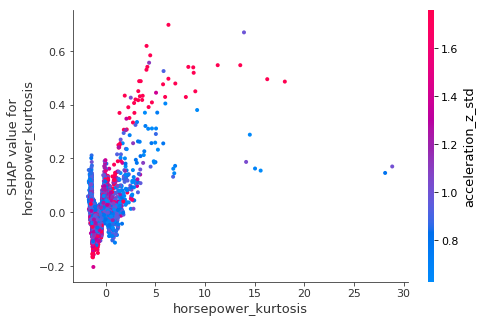

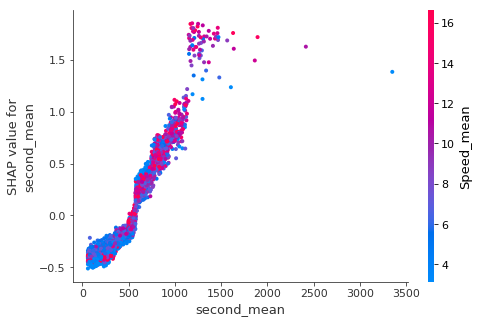

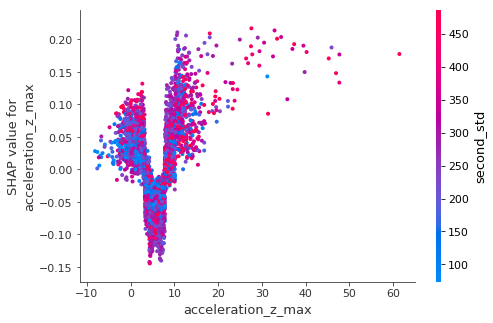

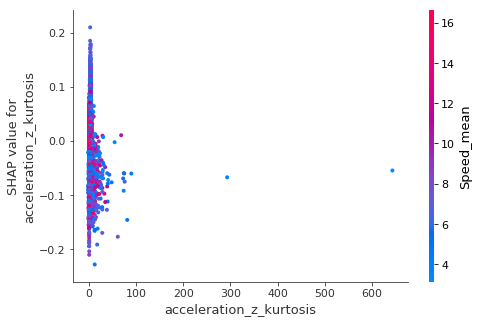

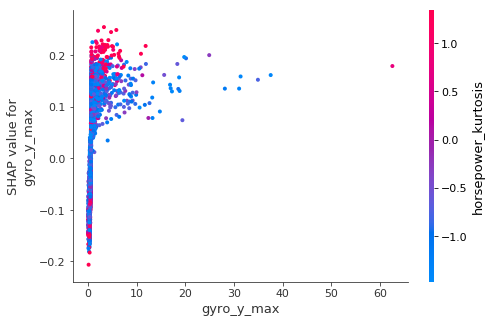

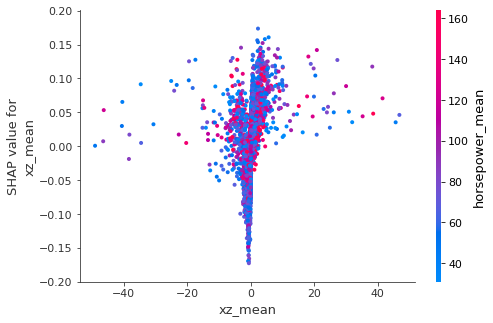

In [174]:
for f in features:
    shap.dependence_plot(f, shap_values, X_valid)

In [0]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Confusion matrix, without normalization


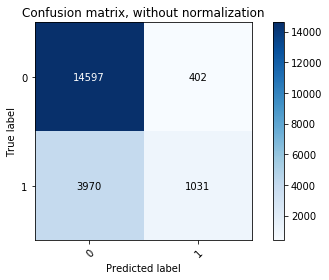

In [179]:
predict_bin = (oof['predict'] > 0.5).astype(int)

# Plot non-normalized confusion matrix
plot_confusion_matrix(oof['label'], predict_bin, classes = np.array([0, 1]),
                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plot_confusion_matrix(oof['label'], predict_bin, classes = np.array([0, 1]),
#                       normalize=True,
#                       title='Confusion matrix, with normalization')

plt.show()